In [1]:
# Math
import numpy as np
from numpy.polynomial import chebyshev

# Plotting
import matplotlib.pyplot as plt
from corner import corner

# Astropy
from astropy.io import fits
from astropy.table import Table

# File manipulation
import wget
import urllib.request
from bs4 import BeautifulSoup
import os
import requests
import re
from threading import Thread
from glob import glob

In [2]:
def is_fits(s):
    fitsPattern = r"apStar-.*\.fits\b"
    matches = re.match(fitsPattern, s)
    return matches

In [3]:
def clean_fits_directory(fields):
    fitsDir = './fits_files'
    for field in fields:
        fieldDir = os.path.join(fitsDir, field)
        fitsFnames = glob(os.path.join(fieldDir, '*'))
        for fname in fitsFnames:
            temp = os.path.split(fname)[-1]
            if not is_fits(temp):
                os.remove(fname)
                print(f"{temp} has been removed bc it is not a .fits file")

def download_fits(fields):
    apogeeUrl = "https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m"
    fitsDir = './fits_files'
    
    for field in fields:
        targetSpectraUrl = os.path.join(apogeeUrl, field)
        targetSpectraOutDir = os.path.join(fitsDir, field)
        if not os.path.exists(targetSpectraOutDir):
            os.makedirs(targetSpectraOutDir)
        
        soup = BeautifulSoup(requests.get(targetSpectraUrl).text)
        for a in soup.find_all('a'):
            link = a['href']
            targetSpectraFname = os.path.join(targetSpectraOutDir, link)
            if os.path.exists(targetSpectraFname):
                continue
            if (is_fits(link)):
                targetSpectraLink = os.path.join(targetSpectraUrl, link)
                try:
                    wget.download(targetSpectraLink, out = targetSpectraFname)
                except:
                    print(f"Something went wrong when downloading '{targetSpectraLink}'")
        print(f"Finished downloading {field} spectra!")
    print("Finished!")

def download_fits_threaded(fields):
    download_thread = Thread(target=download_fits, name="Fits Downloader", args=[fields])
    download_thread.start()
    return download_thread

def count_fits_files():
    fitsDir = './fits_files'
    print(f"{'Dirname':<20} {'Count'}")
    print("-"*(len('Dirname')+20))
    total = 0
    for r, d, files in os.walk(fitsDir):
        root = os.path.split(r)[-1]
        if not root == 'fits_files':
            print(f"{root:<20} {len(files)}")
            total += len(files)
    print(f"{'Total':<20} {total}")

In [4]:
spectraFields = ["M15", "N6791",  "K2_C4_168-21", "060+00"]

In [59]:
# DO NOT RUN THIS AGAIN LMAO
# download_thread = download_fits_threaded(spectraFields)

In [168]:
# Uncomment and run this if download fails
# clean_fits_directory(spectraFields)

apStarLSF-2M21233217+1211528.fits has been removed bc it is not a .fits file
apStarLSF-2M21233366+1147521.fits has been removed bc it is not a .fits file
apStarLSF-2M21234293+1241148.fits has been removed bc it is not a .fits file
apStarLSF-2M21234361+1138228.fits has been removed bc it is not a .fits file
apStarLSF-2M21234362+1217301.fits has been removed bc it is not a .fits file
apStarLSF-2M21234440+1234014.fits has been removed bc it is not a .fits file
apStarLSF-2M21234566+1149290.fits has been removed bc it is not a .fits file
apStarLSF-2M21234647+1135448.fits has been removed bc it is not a .fits file
apStarLSF-2M21234948+1136385.fits has been removed bc it is not a .fits file
apStarLSF-2M21235023+1248359.fits has been removed bc it is not a .fits file
apStarLSF-2M21235294+1210051.fits has been removed bc it is not a .fits file
apStarLSF-2M21235315+1244123.fits has been removed bc it is not a .fits file
apStarLSF-2M21235350+1231119.fits has been removed bc it is not a .fits file

apStarLSF-2M21255345+1058559.fits has been removed bc it is not a .fits file
apStarLSF-2M21255348+1248078.fits has been removed bc it is not a .fits file
apStarLSF-2M21255390+1242480.fits has been removed bc it is not a .fits file
apStarLSF-2M21255469+1222447.fits has been removed bc it is not a .fits file
apStarLSF-2M21255519+1134247.fits has been removed bc it is not a .fits file
apStarLSF-2M21255657+1237443.fits has been removed bc it is not a .fits file
apStarLSF-2M21255850+1208434.fits has been removed bc it is not a .fits file
apStarLSF-2M21255868+1139060.fits has been removed bc it is not a .fits file
apStarLSF-2M21260026+1207036.fits has been removed bc it is not a .fits file
apStarLSF-2M21260054+1256471.fits has been removed bc it is not a .fits file
apStarLSF-2M21260078+1211030.fits has been removed bc it is not a .fits file
apStarLSF-2M21260085+1244585.fits has been removed bc it is not a .fits file
apStarLSF-2M21260157+1210215.fits has been removed bc it is not a .fits file

apStarLSF-2M21273014+1112429.fits has been removed bc it is not a .fits file
apStarLSF-2M21273033+1237392.fits has been removed bc it is not a .fits file
apStarLSF-2M21273038+1138199.fits has been removed bc it is not a .fits file
apStarLSF-2M21273052+1313500.fits has been removed bc it is not a .fits file
apStarLSF-2M21273062+1117287.fits has been removed bc it is not a .fits file
apStarLSF-2M21273157+1205319.fits has been removed bc it is not a .fits file
apStarLSF-2M21273218+1220246.fits has been removed bc it is not a .fits file
apStarLSF-2M21273380+1116376.fits has been removed bc it is not a .fits file
apStarLSF-2M21273456+1141084.fits has been removed bc it is not a .fits file
apStarLSF-2M21273481+1249407.fits has been removed bc it is not a .fits file
apStarLSF-2M21273493+1242426.fits has been removed bc it is not a .fits file
apStarLSF-2M21273608+1227224.fits has been removed bc it is not a .fits file
apStarLSF-2M21273717+1336100.fits has been removed bc it is not a .fits file

apStarLSF-2M21284193+1049011.fits has been removed bc it is not a .fits file
apStarLSF-2M21284423+1315595.fits has been removed bc it is not a .fits file
apStarLSF-2M21284509+1330424.fits has been removed bc it is not a .fits file
apStarLSF-2M21284591+1302320.fits has been removed bc it is not a .fits file
apStarLSF-2M21284604+1315230.fits has been removed bc it is not a .fits file
apStarLSF-2M21284605+1220477.fits has been removed bc it is not a .fits file
apStarLSF-2M21284644+1309200.fits has been removed bc it is not a .fits file
apStarLSF-2M21284667+1117422.fits has been removed bc it is not a .fits file
apStarLSF-2M21284675+1212014.fits has been removed bc it is not a .fits file
apStarLSF-2M21284689+1223220.fits has been removed bc it is not a .fits file
apStarLSF-2M21284724+1326482.fits has been removed bc it is not a .fits file
apStarLSF-2M21284732+1128212.fits has been removed bc it is not a .fits file
apStarLSF-2M21284765+1312588.fits has been removed bc it is not a .fits file

apStarLSF-2M21294165+1158225.fits has been removed bc it is not a .fits file
apStarLSF-2M21294171+1203370.fits has been removed bc it is not a .fits file
apStarLSF-2M21294265+1058156.fits has been removed bc it is not a .fits file
apStarLSF-2M21294295+1209534.fits has been removed bc it is not a .fits file
apStarLSF-2M21294322+1304496.fits has been removed bc it is not a .fits file
apStarLSF-2M21294340+1237503.fits has been removed bc it is not a .fits file
apStarLSF-2M21294351+1210033.fits has been removed bc it is not a .fits file
apStarLSF-2M21294359+1215473.fits has been removed bc it is not a .fits file
apStarLSF-2M21294377+1208332.fits has been removed bc it is not a .fits file
apStarLSF-2M21294408+1209167.fits has been removed bc it is not a .fits file
apStarLSF-2M21294438+1251018.fits has been removed bc it is not a .fits file
apStarLSF-2M21294461+1211321.fits has been removed bc it is not a .fits file
apStarLSF-2M21294465+1207307.fits has been removed bc it is not a .fits file

apStarLSF-2M21300894+1208490.fits has been removed bc it is not a .fits file
apStarLSF-2M21300897+1135291.fits has been removed bc it is not a .fits file
apStarLSF-2M21300902+1240321.fits has been removed bc it is not a .fits file
apStarLSF-2M21300962+1212212.fits has been removed bc it is not a .fits file
apStarLSF-2M21300971+1213424.fits has been removed bc it is not a .fits file
apStarLSF-2M21300978+1212544.fits has been removed bc it is not a .fits file
apStarLSF-2M21300988+1210524.fits has been removed bc it is not a .fits file
apStarLSF-2M21301023+1248077.fits has been removed bc it is not a .fits file
apStarLSF-2M21301034+1118218.fits has been removed bc it is not a .fits file
apStarLSF-2M21301049+1210061.fits has been removed bc it is not a .fits file
apStarLSF-2M21301050+1215542.fits has been removed bc it is not a .fits file
apStarLSF-2M21301057+1214115.fits has been removed bc it is not a .fits file
apStarLSF-2M21301119+1056278.fits has been removed bc it is not a .fits file

apStarLSF-2M21311863+1113365.fits has been removed bc it is not a .fits file
apStarLSF-2M21311898+1158083.fits has been removed bc it is not a .fits file
apStarLSF-2M21311920+1158223.fits has been removed bc it is not a .fits file
apStarLSF-2M21311936+1129141.fits has been removed bc it is not a .fits file
apStarLSF-2M21312014+1306353.fits has been removed bc it is not a .fits file
apStarLSF-2M21312098+1124543.fits has been removed bc it is not a .fits file
apStarLSF-2M21312112+1307399.fits has been removed bc it is not a .fits file
apStarLSF-2M21312115+1300129.fits has been removed bc it is not a .fits file
apStarLSF-2M21312142+1156503.fits has been removed bc it is not a .fits file
apStarLSF-2M21312145+1204060.fits has been removed bc it is not a .fits file
apStarLSF-2M21312315+1302208.fits has been removed bc it is not a .fits file
apStarLSF-2M21312321+1058297.fits has been removed bc it is not a .fits file
apStarLSF-2M21312463+1230046.fits has been removed bc it is not a .fits file

apStarLSF-2M21323548+1302462.fits has been removed bc it is not a .fits file
apStarLSF-2M21323631+1137012.fits has been removed bc it is not a .fits file
apStarLSF-2M21323713+1132550.fits has been removed bc it is not a .fits file
apStarLSF-2M21323750+1314213.fits has been removed bc it is not a .fits file
apStarLSF-2M21323798+1248119.fits has been removed bc it is not a .fits file
apStarLSF-2M21323856+1245032.fits has been removed bc it is not a .fits file
apStarLSF-2M21323962+1226588.fits has been removed bc it is not a .fits file
apStarLSF-2M21323987+1315282.fits has been removed bc it is not a .fits file
apStarLSF-2M21324028+1156012.fits has been removed bc it is not a .fits file
apStarLSF-2M21324063+1146569.fits has been removed bc it is not a .fits file
apStarLSF-2M21324071+1224030.fits has been removed bc it is not a .fits file
apStarLSF-2M21324173+1212196.fits has been removed bc it is not a .fits file
apStarLSF-2M21324254+1209001.fits has been removed bc it is not a .fits file

apStarLSF-2M21340214+1258539.fits has been removed bc it is not a .fits file
apStarLSF-2M21340328+1208100.fits has been removed bc it is not a .fits file
apStarLSF-2M21340497+1206541.fits has been removed bc it is not a .fits file
apStarLSF-2M21340499+1150237.fits has been removed bc it is not a .fits file
apStarLSF-2M21340549+1229020.fits has been removed bc it is not a .fits file
apStarLSF-2M21340560+1148104.fits has been removed bc it is not a .fits file
apStarLSF-2M21340738+1210394.fits has been removed bc it is not a .fits file
apStarLSF-2M21341029+1206118.fits has been removed bc it is not a .fits file
apStarLSF-2M21341060+1157321.fits has been removed bc it is not a .fits file
apStarLSF-2M21341095+1240558.fits has been removed bc it is not a .fits file
apStarLSF-2M21341131+1147245.fits has been removed bc it is not a .fits file
apStarLSF-2M21341222+1306123.fits has been removed bc it is not a .fits file
apStarLSF-2M21341240+1221397.fits has been removed bc it is not a .fits file

apStarLSF-2M19202816+3741194.fits has been removed bc it is not a .fits file
apStarLSF-2M19202870+3743169.fits has been removed bc it is not a .fits file
apStarLSF-2M19203005+3750191.fits has been removed bc it is not a .fits file
apStarLSF-2M19203092+3748450.fits has been removed bc it is not a .fits file
apStarLSF-2M19203184+3830492.fits has been removed bc it is not a .fits file
apStarLSF-2M19203485+3746298.fits has been removed bc it is not a .fits file
apStarLSF-2M19203784+3745249.fits has been removed bc it is not a .fits file
apStarLSF-2M19203934+3748048.fits has been removed bc it is not a .fits file
apStarLSF-2M19204102+3743025.fits has been removed bc it is not a .fits file
apStarLSF-2M19204517+3744339.fits has been removed bc it is not a .fits file
apStarLSF-2M19204557+3739509.fits has been removed bc it is not a .fits file
apStarLSF-2M19204624+3749105.fits has been removed bc it is not a .fits file
apStarLSF-2M19204635+3750228.fits has been removed bc it is not a .fits file

apStarLSF-2M19265030+3855169.fits has been removed bc it is not a .fits file
apStarLSF-2M19265119+3835101.fits has been removed bc it is not a .fits file
apStarLSF-2M19265273+3906334.fits has been removed bc it is not a .fits file
apStarLSF-2M19265491+3756300.fits has been removed bc it is not a .fits file
apStarLSF-2M19265532+3814054.fits has been removed bc it is not a .fits file
apStarLSF-2M19265550+3844381.fits has been removed bc it is not a .fits file
apStarLSF-2M19270402+3737475.fits has been removed bc it is not a .fits file
apStarLSF-2M19270827+3842115.fits has been removed bc it is not a .fits file
apStarLSF-2M19270994+3857504.fits has been removed bc it is not a .fits file
apStarLSF-2M19271735+3910199.fits has been removed bc it is not a .fits file
apStarLSF-2M19271763+3913024.fits has been removed bc it is not a .fits file
apStarLSF-2M19271866+3803190.fits has been removed bc it is not a .fits file
apStarLSF-2M19271886+3652262.fits has been removed bc it is not a .fits file

apStarLSF-2M03522897+2422342.fits has been removed bc it is not a .fits file
apStarLSF-2M03523407+2439148.fits has been removed bc it is not a .fits file
apStarLSF-2M03523603+2449263.fits has been removed bc it is not a .fits file
apStarLSF-2M03523655+2524594.fits has been removed bc it is not a .fits file
apStarLSF-2M03523746+2504581.fits has been removed bc it is not a .fits file
apStarLSF-2M03523764+2444550.fits has been removed bc it is not a .fits file
apStarLSF-2M03523939+2528520.fits has been removed bc it is not a .fits file
apStarLSF-2M03523981+2436069.fits has been removed bc it is not a .fits file
apStarLSF-2M03524101+2548159.fits has been removed bc it is not a .fits file
apStarLSF-2M03524240+2551314.fits has been removed bc it is not a .fits file
apStarLSF-2M03524249+2507029.fits has been removed bc it is not a .fits file
apStarLSF-2M03524323+2538332.fits has been removed bc it is not a .fits file
apStarLSF-2M03524534+2516475.fits has been removed bc it is not a .fits file

apStarLSF-2M03555595+2519521.fits has been removed bc it is not a .fits file
apStarLSF-2M03555815+2412444.fits has been removed bc it is not a .fits file
apStarLSF-2M03555902+2407449.fits has been removed bc it is not a .fits file
apStarLSF-2M03560095+2542448.fits has been removed bc it is not a .fits file
apStarLSF-2M03560101+2625285.fits has been removed bc it is not a .fits file
apStarLSF-2M03560119+2403343.fits has been removed bc it is not a .fits file
apStarLSF-2M03560136+2346520.fits has been removed bc it is not a .fits file
apStarLSF-2M03560190+2426392.fits has been removed bc it is not a .fits file
apStarLSF-2M03560370+2553554.fits has been removed bc it is not a .fits file
apStarLSF-2M03560378+2621528.fits has been removed bc it is not a .fits file
apStarLSF-2M03560443+2420209.fits has been removed bc it is not a .fits file
apStarLSF-2M03560471+2627388.fits has been removed bc it is not a .fits file
apStarLSF-2M03560691+2551346.fits has been removed bc it is not a .fits file

apStarLSF-2M03593027+2507575.fits has been removed bc it is not a .fits file
apStarLSF-2M03593084+2415572.fits has been removed bc it is not a .fits file
apStarLSF-2M03593643+2538081.fits has been removed bc it is not a .fits file
apStarLSF-2M03594050+2443599.fits has been removed bc it is not a .fits file
apStarLSF-2M03594143+2543200.fits has been removed bc it is not a .fits file
apStarLSF-2M03594241+2602331.fits has been removed bc it is not a .fits file
apStarLSF-2M03594266+2614599.fits has been removed bc it is not a .fits file
apStarLSF-2M03594371+2600421.fits has been removed bc it is not a .fits file
apStarLSF-2M03594624+2535266.fits has been removed bc it is not a .fits file
apStarLSF-2M03594675+2403447.fits has been removed bc it is not a .fits file
apStarLSF-2M03594815+2556198.fits has been removed bc it is not a .fits file
apStarLSF-2M03594818+2505335.fits has been removed bc it is not a .fits file
apStarLSF-2M03594909+2513164.fits has been removed bc it is not a .fits file

apStarLSF-2M19391333+2315441.fits has been removed bc it is not a .fits file
apStarLSF-2M19391644+2446410.fits has been removed bc it is not a .fits file
apStarLSF-2M19391884+2433455.fits has been removed bc it is not a .fits file
apStarLSF-2M19392027+2328086.fits has been removed bc it is not a .fits file
apStarLSF-2M19392304+2428597.fits has been removed bc it is not a .fits file
apStarLSF-2M19392328+2317404.fits has been removed bc it is not a .fits file
apStarLSF-2M19392333+2335204.fits has been removed bc it is not a .fits file
apStarLSF-2M19392443+2326151.fits has been removed bc it is not a .fits file
apStarLSF-2M19392548+2301304.fits has been removed bc it is not a .fits file
apStarLSF-2M19392565+2357265.fits has been removed bc it is not a .fits file
apStarLSF-2M19392581+2411403.fits has been removed bc it is not a .fits file
apStarLSF-2M19392667+2430456.fits has been removed bc it is not a .fits file
apStarLSF-2M19392788+2347244.fits has been removed bc it is not a .fits file

apStarLSF-2M19411511+2306328.fits has been removed bc it is not a .fits file
apStarLSF-2M19411534+2416017.fits has been removed bc it is not a .fits file
apStarLSF-2M19411578+2422407.fits has been removed bc it is not a .fits file
apStarLSF-2M19411640+2314077.fits has been removed bc it is not a .fits file
apStarLSF-2M19411688+2252106.fits has been removed bc it is not a .fits file
apStarLSF-2M19411740+2355357.fits has been removed bc it is not a .fits file
apStarLSF-2M19411744+2247095.fits has been removed bc it is not a .fits file
apStarLSF-2M19411765+2445157.fits has been removed bc it is not a .fits file
apStarLSF-2M19411779+2345556.fits has been removed bc it is not a .fits file
apStarLSF-2M19411905+2446287.fits has been removed bc it is not a .fits file
apStarLSF-2M19411924+2421071.fits has been removed bc it is not a .fits file
apStarLSF-2M19412011+2407228.fits has been removed bc it is not a .fits file
apStarLSF-2M19412028+2240100.fits has been removed bc it is not a .fits file

apStarLSF-2M19430641+2235013.fits has been removed bc it is not a .fits file
apStarLSF-2M19430701+2500284.fits has been removed bc it is not a .fits file
apStarLSF-2M19430702+2435525.fits has been removed bc it is not a .fits file
apStarLSF-2M19430733+2423263.fits has been removed bc it is not a .fits file
apStarLSF-2M19430780+2322443.fits has been removed bc it is not a .fits file
apStarLSF-2M19430841+2242397.fits has been removed bc it is not a .fits file
apStarLSF-2M19430847+2428278.fits has been removed bc it is not a .fits file
apStarLSF-2M19430955+2513158.fits has been removed bc it is not a .fits file
apStarLSF-2M19430973+2357587.fits has been removed bc it is not a .fits file
apStarLSF-2M19431000+2252211.fits has been removed bc it is not a .fits file
apStarLSF-2M19431096+2317454.fits has been removed bc it is not a .fits file
apStarLSF-2M19431157+2421105.fits has been removed bc it is not a .fits file
apStarLSF-2M19431217+2434322.fits has been removed bc it is not a .fits file

In [169]:
if (download_thread.is_alive()):
    print("Download is still running...")
count_fits_files()

Dirname              Count
---------------------------
060+00               998
K2_C4_168-21         439
M15                  1334
N6791                265
Total                3036


In [5]:
def get_fits_fname_by_idx(field, idx):
    fitsDir = './fits_files'
    fieldDir = os.path.join(fitsDir, field)
    fullFname = glob(os.path.join(fieldDir, '*'))[idx]
    return os.path.join(field, os.path.split(fullFname)[-1])

In [6]:
wl_start = 4.179
wl_delta = 6e-06
wl_count = 8575
wavelengths = np.logspace(wl_start, wl_start+wl_delta*wl_count, wl_count, base=10)

def get_fits_flux(fitsFname):
    fitsDir = './fits_files'
    fitsFname = os.path.join(fitsDir, fitsFname)
    with fits.open(fitsFname) as hdul:
        objID = hdul[0].header['OBJID']
        hduFlux = hdul[1]
        hduFluxErr = hdul[2]
        hduMask = hdul[3]
        
        flux = np.array(hduFlux.data.reshape(-1, wl_count)[0])
        fluxErr = np.array(hduFluxErr.data.reshape(-1, wl_count)[0])
        
        nullMask = (flux == 0)
        binaryMask = (hduMask.data[0] & 0b100001111111) != 0
        
        flux[nullMask] = np.nan
        fluxErr[nullMask] = np.nan
        fluxErr[binaryMask] *= 10
        
        return objID, flux, fluxErr

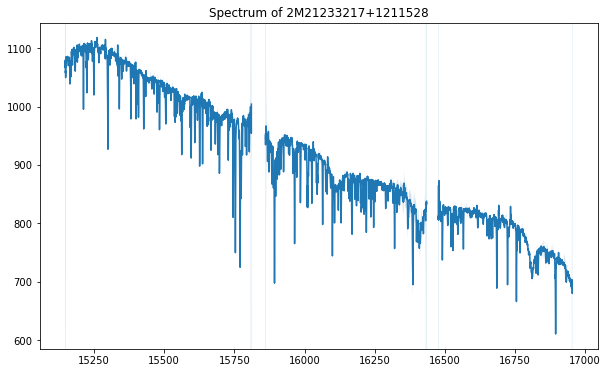

In [7]:
fitsFname = get_fits_fname_by_idx(spectraFields[0], 0)
objID, flux, fluxErr = get_fits_flux(fitsFname)
plt.figure(figsize = (10,6))
plt.title(f"Spectrum of {objID}")
plt.plot(wavelengths, flux)
plt.ylim(plt.ylim())

plt.fill_between(wavelengths, flux-fluxErr, flux+fluxErr, alpha=0.2)
plt.show()

In [8]:
def load_all_stars(fields):
    fitsDir = './fits_files'
    allStarFname = 'allStarLite-r12-l33.fits'
    allStarPath = os.path.join(fitsDir, allStarFname)
    
    mainCols = [
        'LOGG',
        'TEFF',
        'M_H',
        'MG_FE',
        'SI_FE'
    ]
    metaCols = [
        'APOGEE_ID',
        'FIELD',
        'SNR',
        'ASPCAPFLAGS'
    ]
    
    errCols = [col + '_ERR' for col in mainCols]
    
    allStars = Table.read(allStarPath)
    allStars = allStars[np.isin(allStars['FIELD'].astype(str), fields)]
    allStars = allStars[metaCols + mainCols + errCols]
    
    snrMask = (allStars['SNR'] >= 50.0)
    loggMask = (allStars['LOGG'] <= 4.0)
    teffMask = (allStars['TEFF'] <= 5700.0)
    m_hMask = (allStars['M_H'] >= -1.0)
    
    errMask = np.ones(len(allStars), dtype=bool)
    for errField in errCols:
        errMask = errMask&(allStars[errField] >= 0.0)
    
    allStars = allStars[snrMask & loggMask & teffMask & m_hMask & errMask]
    allStars['index'] = np.arange(len(allStars))
    
    return allStars

In [9]:
mainCols = [
        'LOGG',
        'TEFF',
        'M_H',
        'MG_FE',
        'SI_FE'
    ]
allStars = load_all_stars(spectraFields)

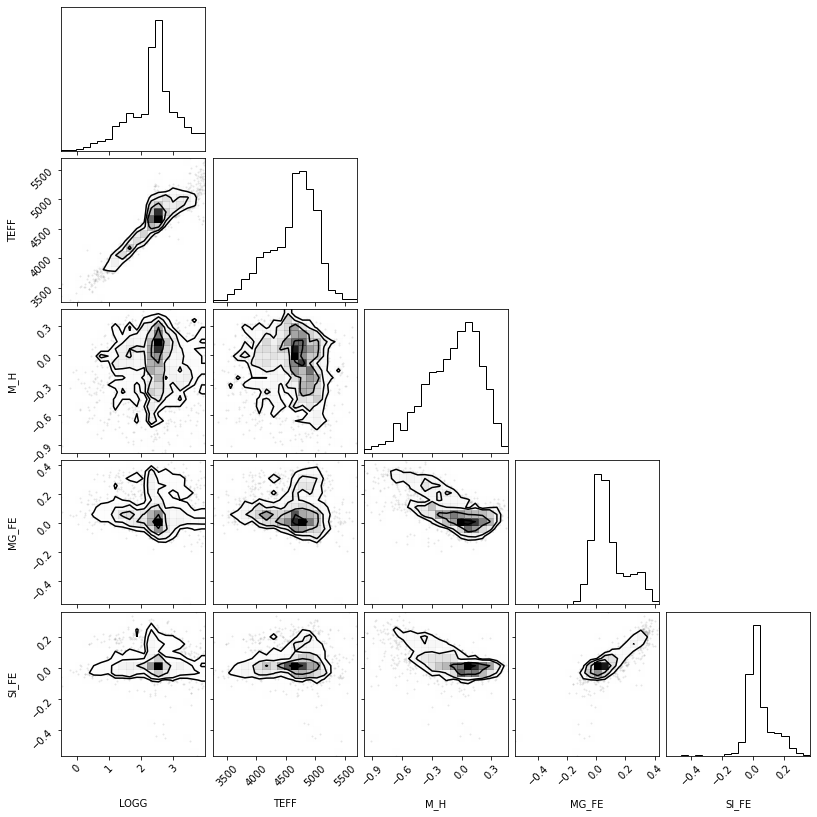

In [10]:
corner(allStars[mainCols].to_pandas())
pass

In [11]:
def get_is_continuum(wavelengths):
    with np.load('continuum_pixels_apogee.npz') as npz:
        cpaWavelengths = npz['wavelength']
        cpaIsContinuum = npz['is_continuum']
    wavelengthsIsContinuum = (0.5 < np.around(np.interp(wavelengths, cpaWavelengths, cpaIsContinuum)))
    return wavelengthsIsContinuum

cpaChips = np.array([
    [ 15170.8, 15785.0 ],
    [ 15904.7, 16395.7 ],
    [ 16503.3, 16930.5 ]
])

In [12]:
def pseudo_normalize(wavelengths, flux, fluxErr, deg):
    
    wavelengthsIsContinuum = get_is_continuum(wavelengths)
    isContinuumMask = wavelengthsIsContinuum & np.isfinite(flux)
    
    pseudoFlux = np.full(flux.shape, np.nan)
    
    for lo, hi in cpaChips:
        rangeMask = (wavelengths >= lo) & (wavelengths <= hi)
        mask = isContinuumMask & rangeMask
        
        chebCoeff = chebyshev.chebfit(wavelengths[mask], flux[mask], deg=deg, w=1/np.sqrt(fluxErr[mask]))
        pseudoFlux[rangeMask] = chebyshev.chebval(wavelengths[rangeMask], chebCoeff)
    
    fluxNorm = flux/pseudoFlux
    fluxErrNorm = fluxErr/pseudoFlux
    
    return fluxNorm, fluxErrNorm, pseudoFlux

In [13]:
def get_star_by_id(apogeeID):
#     allStars = load_all_stars(spectraFields)
    return allStars[allStars['APOGEE_ID'] == apogeeID][0]

def get_fits_by_id(apogeeID):
    fitsDir = './fits_files'
    for r, d, files in os.walk(fitsDir):
        for file in files:
            if apogeeID in file:
#                 print(r, d, file)
#                 print(os.path.join(r, d, file))
                field = os.path.split(r)[-1]
                return get_fits_flux(os.path.join(field, file))
    

In [18]:
def plot_pseudo_normalized(apogeeID, deg=5):
    a, flux, fluxErr = get_fits_by_id(apogeeID)
    
    fluxNorm, fluxErrNorm, pseudoFlux = pseudo_normalize(wavelengths, flux, fluxErr, deg)
    
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,8))
    fig.suptitle(apogeeID)
    ax1.set(title='Spectrum', ylabel='Flux')
    ax1.plot(wavelengths, flux, lw=0.5, label='Spectrum')
    ax1.set_ylim(ax1.get_ylim())
    ax1.plot(wavelengths, pseudoFlux, label='Pseudo Continuum')
    ax1.fill_between(wavelengths, flux-fluxErr, flux+fluxErr, alpha=0.15)
    ax1.legend()
    
    ax2.plot(wavelengths, fluxNorm, lw=0.5)
    ax2.axhline(1, 0, 1, c='k', lw=1)
    ax2.set_ylim(ax2.get_ylim())
    ax2.fill_between(wavelengths, fluxNorm-fluxErrNorm, fluxNorm+fluxErrNorm, alpha=0.15)
    ax2.set(xlabel='Wavelength (Ang)', ylabel='NormalizedFlux', title="Pseudo-Normalized Spectrum")
    
    plt.show()

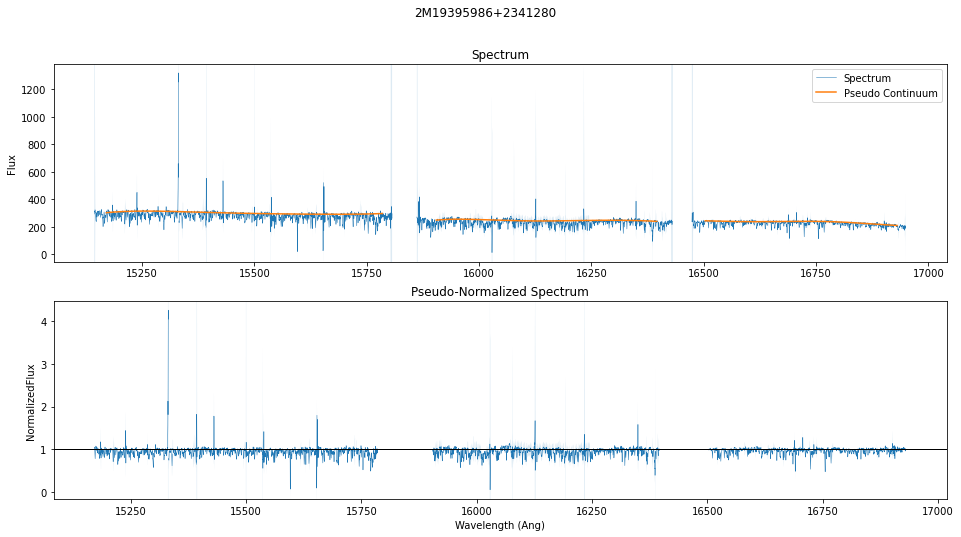

In [19]:
apogeeID = '2M19395986+2341280'
plot_pseudo_normalized(apogeeID)

In [21]:
allSpectraFname = 'allSpectra.npz'
if os.path.exists(allSpectraFname):
    print(f"Loading spectra from {allSpectraFname}")
    with np.load(allSpectraFname) as allSpectraNPZ:
        spectraFluxNorm = allSpectraNPZ['fluxNorm']
        spectraFluxErrNorm = allSpectraNPZ['fluxErrNorm']
        spectraPseudoNorm = allSpectraNPZ['pseudoNorm']
else:
    spectraFluxNorm = np.empty((len(allStars), wl_count))
    spectraFluxErrNorm = np.empty(spectraFluxNorm.shape)
    spectraPseudoNorm = np.empty(spectraFluxNorm.shape)
    
    for i, star in enumerate(allStars):
        apogeeID = star['APOGEE_ID']
        a, flux, fluxErr = get_fits_by_id(apogeeID)
        spectraFluxNorm[i], spectraFluxErrNorm[i], spectraPseudoNorm[i] = pseudo_normalize(wavelengths, flux,fluxErr,deg=5)
        
    np.savez_compressed(allSpectraFname, spectraFluxNorm = spectraFluxNorm, spectraFluxErrNorm = spectraFluxErrNorm, spectraPseudoNorm=spectraPseudoNorm)
        

NameError: name 'allspectra_path' is not defined

In [22]:
np.savez_compressed(allSpectraFname, spectraFluxNorm = spectraFluxNorm, spectraFluxErrNorm = spectraFluxErrNorm, spectraPseudoNorm=spectraPseudoNorm)
    